In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
#GPU
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Loading data from HuggingFace

In [3]:
#Buttefly dataset
dts_name="huggan/smithsonian_butterflies_subset"
data_but=load_dataset(dts_name, split='train')
data_but

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

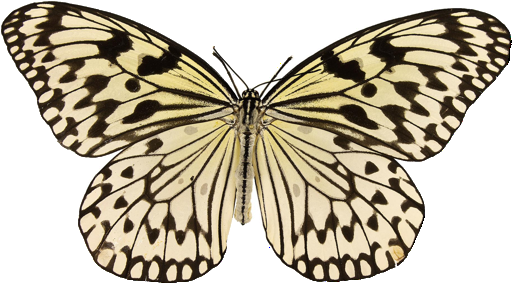

In [ ]:
data_but_small=data_but['image']
#sample of datatset
data_but_small[0]

In [5]:
#Dog dataset
data=load_dataset('amaye15/stanford-dogs')
#data_dogs=concatenate_datasets([data['train'], data['test']])
data_dogs=data['test']
data_dogs=data_dogs.rename_column('pixel_values','image')
data_dogs=data_dogs.remove_columns('label')
data_dogs

Dataset({
    features: ['image'],
    num_rows: 6174
})

Customize dataset

In [6]:
#Transforme image in tensor
img_size=64
trans=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5,0.5), (0.5, 0.5,0.5))
    
])

In [7]:
img=data_but_small[0]
img=trans(img)
img.shape

torch.Size([3, 64, 64])

In [8]:
class cus_dts(Dataset):
    def __init__(self, data, transforms):
        self.data=data
        self.transforms=transforms
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img=self.data[idx]['image']
        img=self.transforms(img)
        return img


In [9]:
dts_ts=cus_dts(data_but, trans)
dts_ts[0].shape

torch.Size([3, 64, 64])

In [10]:
len(dts_ts)

1000

In [11]:
# data loader
batch_size=32
data_loader=DataLoader(dts_ts, batch_size=batch_size)

In [12]:
for i, batch_img in enumerate(data_loader):
    print(batch_img.shape)
    break

torch.Size([32, 3, 64, 64])


Generator model

In [13]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3,  kernel=4, strides=2, padding=1):
        super (G_block, self).__init__()
        self.layers=nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        x=self.layers(x)
        return x

In [14]:
x=torch.zeros(8,3, 32, 32)
gblock=G_block(100)
gblock(x).shape

torch.Size([8, 100, 64, 64])

In [15]:
#Generate a vector 100-dimension to an image (3,64,64)
n_G=64
net_G=nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8, strides=1, padding=0),#512x4x4
    G_block(in_channels=8*n_G, out_channels=n_G*4),#256x8x8
    G_block(in_channels=4*n_G, out_channels=n_G*2),#128x16x16
    G_block(in_channels=2*n_G, out_channels=n_G),#64x32x32
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,#3x64x64
                       kernel_size=4, stride=2, padding=1),
    nn.Tanh()
).to(device)

In [16]:
x=torch.zeros(1,100,1,1).to(device) # a noise
net_G(x).shape  # An image size

torch.Size([1, 3, 64, 64])

Discriminator model

In [17]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1):
        super(D_block, self).__init__()
        self.layers=nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size,
                      strides, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self,x):
        return self.layers(x)

In [18]:
x=torch.zeros((8,3,64,64))
d_block=D_block(100)
d_block(x).shape

torch.Size([8, 100, 32, 32])

In [19]:
n_D=64
net_D=nn.Sequential(
    D_block(n_D),#64x32x32
    D_block(in_channels=n_D, out_channels=n_D*2),#128*16*16
    D_block(in_channels=n_D*2, out_channels=n_D*4),#256*8*8
    D_block(in_channels=n_D*4, out_channels=n_D*8),#512*4*4
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4),#1,1,1
    nn.Sigmoid()
).to(device)

In [20]:
x=torch.zeros((8,3,64,64)).to(device)
net_D(x).shape

torch.Size([8, 1, 1, 1])

Training

In [21]:
latent_dim=100
#Loading models
net_G=net_G.to(device)
net_D=net_D.to(device)
#Initialize  parameters
for w in net_D.parameters():
    nn.init.normal_(w,0,0.02)
for w in net_G.parameters():
    nn.init.normal_(w,0,0.02)
#Optimization
opt_G=torch.optim.Adam(net_G.parameters(), lr=0.0002, betas=(0.5, 0.9999))
opt_D=torch.optim.Adam(net_D.parameters(), lr=0.0002, betas=(0.5, 0.9999))
#Loss function
criterion=nn.BCELoss() #reduction='sum')
#noise
noise_fix=torch.randn(batch_size, latent_dim,1,1, device=device)

In [22]:
n_epochs=101
img_list=[]
G_losses=[]
D_losses=[]
for epoch in range(n_epochs):
    Loss=0
    for i, imgs in enumerate(data_loader):
        #Update Discriminator
        #############
        net_D.zero_grad()
        imgs=imgs.to(device)
        #D_forward
        out_put=net_D(imgs).view(-1)
        #Loss D_real
        loss_D_real=criterion(out_put,torch.ones_like(out_put, device=device))
        #D_backward
        loss_D_real.backward()
        #############
        # the noise
        noise=torch.normal(0,1, size=(batch_size, latent_dim,1,1), device=device)
        #Generate noise
        fake=net_G(noise)
        #Passing to discriminator
        out_put=net_D(fake.detach()).view(-1)
        #loss D_fake
        loss_D_fake=criterion(out_put, torch.zeros_like(out_put,device=device))
        loss_D_fake.backward()
        loss_D=loss_D_real+loss_D_fake
        #Update discriminator
        opt_D.step()
        ################
        #Update G-network
        net_G.zero_grad()
        out_put=net_D(fake).view(-1)
        loss_G=criterion(out_put, torch.ones_like(out_put,device=device))
        #G-backward
        loss_G.backward()
        #G-update
        opt_G.step()
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
    if epoch%10==0:
        print(f'Epoch: {epoch}, G_loss: {loss_G}, D_fake_loss: {loss_D_fake}, and D_loss: {loss_D}')
        with torch.no_grad():
            imgs_noise=net_G(noise_fix).detach()
        imgs=torchvision.utils.make_grid(imgs_noise, nrow=8)
        img_list.append(imgs)
        

Epoch: 0, G_loss: 2.2321152687072754, D_fake_loss: 0.12424451112747192, and D_loss: 0.2464655041694641
Epoch: 10, G_loss: 2.38675594329834, D_fake_loss: 0.32437917590141296, and D_loss: 0.6115808486938477
Epoch: 20, G_loss: 2.4129209518432617, D_fake_loss: 0.32298287749290466, and D_loss: 0.6021367311477661
Epoch: 30, G_loss: 2.626983880996704, D_fake_loss: 0.27485430240631104, and D_loss: 0.5672007203102112
Epoch: 40, G_loss: 2.424164295196533, D_fake_loss: 0.1555004119873047, and D_loss: 0.5738890171051025
Epoch: 50, G_loss: 4.39114236831665, D_fake_loss: 0.805928111076355, and D_loss: 0.8439871668815613
Epoch: 60, G_loss: 3.9411778450012207, D_fake_loss: 0.3222888708114624, and D_loss: 0.37311625480651855
Epoch: 70, G_loss: 3.567087173461914, D_fake_loss: 0.35117918252944946, and D_loss: 0.4421398639678955
Epoch: 80, G_loss: 2.438663959503174, D_fake_loss: 0.21064850687980652, and D_loss: 0.4859966039657593
Epoch: 90, G_loss: 4.742228984832764, D_fake_loss: 0.1975574493408203, and D

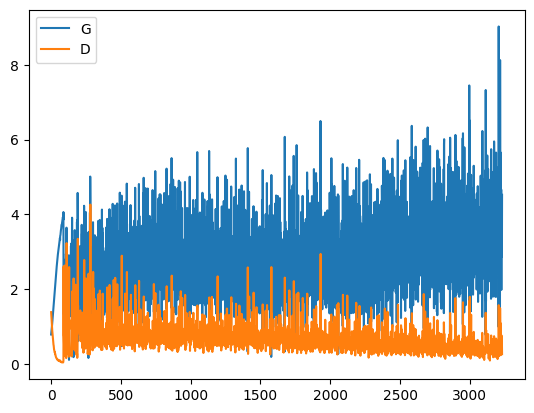

In [23]:
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.legend()

Results

Text(0.5, 1.0, 'Real images')

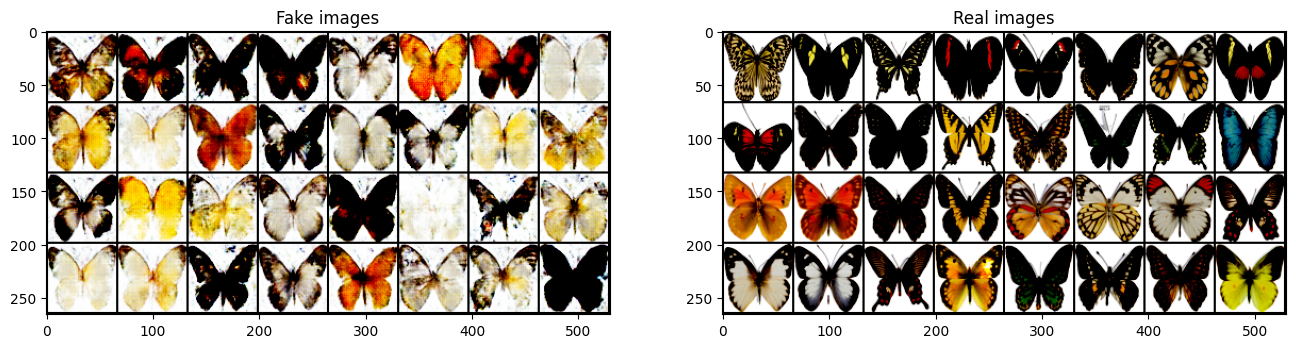

In [24]:
imgs_fake=net_G(noise_fix)
grid_fake=torchvision.utils.make_grid(imgs_fake, nrow=8)
grid_real=torchvision.utils.make_grid(batch_img, nrow=8)
plt.subplots(1,2, figsize=(16,7))
plt.subplot(1,2,1)
plt.imshow(grid_fake.permute(1,2,0).cpu().clip(0,1)) 
plt.title('Fake images')
plt.subplot(1,2,2)
plt.imshow(grid_real.permute(1,2,0).clip(0,1)) 
plt.title('Real images')
